# Lorenz Lyapunov Testing

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps

np.random.seed(100)

### Define Lorenz System:

In [2]:
sigma = 9
rho = 22
beta = 8/3

def lorenz(t, x):
    return [
        sigma*(x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ]

### Create Training Data:

In [3]:
dt = 0.01  # Timestep

# First trajectory:
t_train1 = np.arange(0,10,dt)  # Time range to integrate over
x0_train1 = [-1,1,-1]  # Initial conditions
sol1 = solve_ivp(lorenz, (t_train1[0], t_train1[-1]), x0_train1, t_eval=t_train1)  # Integrate to produce x(t),y(t),z(t)
x_train1 = np.transpose(sol1.y)  
print(x_train1)

# Second trajectory:
t_train2 = np.arange(100,110,dt)  # Time range to integrate over
x0_train2 = [2,-2,2]  # Initial conditions
sol2 = solve_ivp(lorenz, (t_train2[0], t_train2[-1]), x0_train2, t_eval=t_train2) # Integrate to produce x(t),y(t),z(t)
x_train2 = np.transpose(sol2.y)  

# Add noise to both our trajectories:
x_train1 += np.random.normal(scale = 0.05, size=x_train1.shape) 
x_train2 += np.random.normal(scale = 0.05, size=x_train2.shape) 

# Combine both trajectory data sets into a list:
x_train = [x_train1, x_train2]

[[-1.          1.         -1.        ]
 [-0.83809836  0.77132513 -0.98169563]
 [-0.70818644  0.57984721 -0.96098159]
 ...
 [ 6.17174986  5.30175659 21.42988142]
 [ 6.09898425  5.35225077 21.18837111]
 [ 6.03739174  5.41550836 20.95309619]]


### Create SINDy Model:

In [4]:
stlsq_opt = ps.STLSQ(threshold = 0.1) # Set threshold
model = ps.SINDy(optimizer=stlsq_opt)
model.fit(x_train, t=dt, multiple_trajectories=True)
model.print()

x0' = -8.975 x0 + 8.980 x1
x1' = 22.574 x0 + -0.908 x1 + -0.984 x0 x2
x2' = -2.658 x2 + 0.996 x0 x1


### Create test trajectory:

In [5]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 100, dt)  # Longer time range
x0_test = np.array([8, 7, 15])  # New initial conditions
sol = solve_ivp(lorenz, (t_test[0], t_test[-1]), x0_test, t_eval=t_test) # Integrate to produce x(t),y(t),z(t)
x_test = np.transpose(sol.y)  

print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.999820


### Simulate forward in time

In [6]:
x_test_sim = model.simulate(x0_test, t_test)

[Text(0.5, 0, '$x_0$'),
 Text(0.5, 0, '$x_1$'),
 Text(0.5, 0, '$x_2$'),
 Text(0.5, 0.92, 'model simulation')]

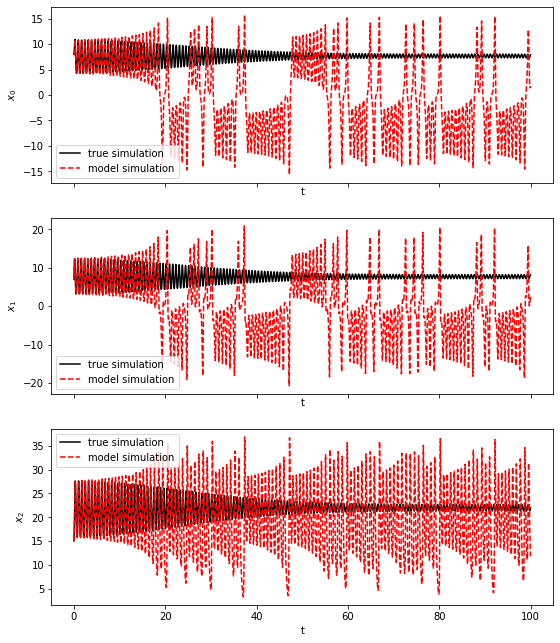

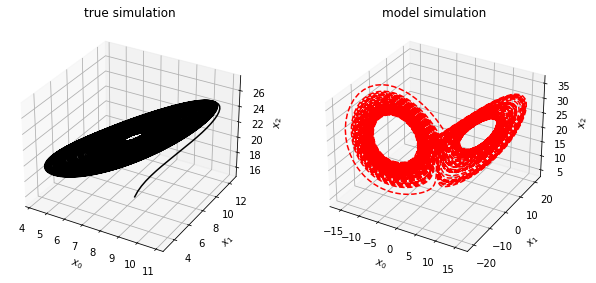

In [7]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(9,11))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))
    #axs[i].set_xlim(80,100)
    
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

In [8]:
epsilon = 0.01  # Pertibation Amplitude
T = 1  # Integral time interval
M = 100  # Integral iterations
N = 3 # Number of state variables in our system

In [9]:
# Reference vector:
x = [8,7,15]

# Perturbed vector:
x_tilda = np.zeros((N,N))

# Perturned vector relative to reference vector
x_tilda_r = np.zeros((N,N))

# Orthonormalised perturbed vector
x_tilda_0 = [[8+epsilon, 7, 15],
             [8, 7+epsilon, 15],
             [8, 7, 15+epsilon]]

x_tilda_0_r = np.zeros((N,N))

S = np.zeros(N)

In [10]:
for i in range(M):
    # Integrate reference vector over time T:
    sol = solve_ivp(lorenz, (i*T, (i+1)*T), x, method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
    x = (np.transpose(sol.y))[-1]     
    
    for j in range(N):
        # Integrate each perturbation vector over time T:
        # x_tilda(j) = final value of integral from (x_tilda_0(j)) over T
        sol = solve_ivp(lorenz, (i*T, (i+1)*T), x_tilda_0[j], method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
        x_tilda[j] = (np.transpose(sol.y))[-1]
        
        # Find the relative vector between each perturbation vector and the refernce vector:
        x_tilda_r[j] = x_tilda[j] - x
            
    # Complete a gram schmidt orthogonalization process on relative perturbed vectors:  
    for j in range(N):
        for k in range(j):
            x_tilda_r[j] = x_tilda_r[j] - (np.dot(x_tilda_r[k], x_tilda_r[j])/np.dot(x_tilda_r[k], x_tilda_r[k])) * x_tilda_r[k]
            
        # Update the accumulated sums with the new relative vector:
        S[j] = S[j] + np.log(np.linalg.norm(x_tilda_r[j]/epsilon))
        
        x_tilda_0_r[j] = x_tilda_r[j] * epsilon / np.linalg.norm(x_tilda_r[j])
        
        # Compute the absolute vectors for the next iteration:
        x_tilda_0[j] = x + x_tilda_0_r[j]

In [11]:
L_exp = S/(M*T)

print(L_exp)

[ 0.73855357  0.19485139 -5.45348228]
